In [1]:
# -*- coding: utf-8 -*-

# This is a report using the data from IQAASL.
# IQAASL was a project funded by the Swiss Confederation
# It produces a summary of litter survey results for a defined region.
# These charts serve as the models for the development of plagespropres.ch
# The data is gathered by volunteers.
# Please remember all copyrights apply, please give credit when applicable
# The repo is maintained by the community effective January 01, 2022
# There is ample opportunity to contribute, learn and teach
# contact dev@hammerdirt.ch

# Dies ist ein Bericht, der die Daten von IQAASL verwendet.
# IQAASL war ein von der Schweizerischen Eidgenossenschaft finanziertes Projekt.
# Es erstellt eine Zusammenfassung der Ergebnisse der Littering-Umfrage für eine bestimmte Region.
# Diese Grafiken dienten als Vorlage für die Entwicklung von plagespropres.ch.
# Die Daten werden von Freiwilligen gesammelt.
# Bitte denken Sie daran, dass alle Copyrights gelten, bitte geben Sie den Namen an, wenn zutreffend.
# Das Repo wird ab dem 01. Januar 2022 von der Community gepflegt.
# Es gibt reichlich Gelegenheit, etwas beizutragen, zu lernen und zu lehren.
# Kontakt dev@hammerdirt.ch

# Il s'agit d'un rapport utilisant les données de IQAASL.
# IQAASL était un projet financé par la Confédération suisse.
# Il produit un résumé des résultats de l'enquête sur les déchets sauvages pour une région définie.
# Ces tableaux ont servi de modèles pour le développement de plagespropres.ch
# Les données sont recueillies par des bénévoles.
# N'oubliez pas que tous les droits d'auteur s'appliquent, veuillez indiquer le crédit lorsque cela est possible.
# Le dépôt est maintenu par la communauté à partir du 1er janvier 2022.
# Il y a de nombreuses possibilités de contribuer, d'apprendre et d'enseigner.
# contact dev@hammerdirt.ch

# sys, file and nav packages:
import datetime as dt

# for date and month formats in french or german
import locale

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
import seaborn as sns
import matplotlib.gridspec as gridspec

# home brew utitilties
import resources.chart_kwargs as ck

import resources.sr_ut as sut

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex
import matplotlib.image as mpimg

# set the locale to the language desired
# the locale is set back to to original at the the end of the script
# loc = locale.getlocale()
# lang =  "de_DE.utf8"
# locale.setlocale(locale.LC_ALL, lang)

# # the date is in iso standard:
# d = "%Y-%m-%d"

# # it gets changed to german format
# g = "%d.%m.%Y"

# set some parameters:
start_date = "2020-03-01"
end_date ="2021-05-31"
start_end = [start_date, end_date]
a_fail_rate = 50
unit_label = "p/100m"

sns.set_style('whitegrid')
a_color = 'dodgerblue'

# set the maps
bassin_map = PILImage.open("resources/maps/survey_locations_all.jpeg")

# common aggregations
agg_pcs_quantity = {unit_label:"sum", "quantity":"sum"}
agg_pcs_median = {unit_label:"median", "quantity":"sum"}

# aggregation of dimensional data
agg_dims = {"total_w":"sum", "mac_plast_w":"sum", "area":"sum", "length":"sum"}

# define the components
comps = ['linth', 'rhone', 'aare', 'ticino']
comp_labels = {"linth":"Linth/Limmat", "rhone":"Rhône", 'aare':"Aare", "ticino":"Ticino/Cerisio", "reuss":"Reuss"}


# explanatory variables:
luse_exp = ['% to buildings', '% to recreation', '% to agg', '% to woods', 'streets km', 'intersects']

# columns needed
use_these_cols = ['loc_date' ,
                  '% to buildings',
                  '% to trans', 
                  '% to recreation',
                  '% to agg',
                  '% to woods',
                  'population',
                  'river_bassin',
                  'water_name_slug',
                  'streets km',
                  'intersects',
                  'length',
                  'groupname',
                  'code'
                 ]

# these are default
top_name = ["Alle"]

# add the folder to the directory tree:


# get your data:
survey_data = pd.read_csv('resources/checked_sdata_eos_2020_21.csv')
# river_bassins = ut.json_file_get("resources/river_basins.json")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfDims = pd.read_csv("resources/corrected_dims.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

dfCodes.set_index("code", inplace=True)

# language specific
# importing german code descriptions
de_codes = pd.read_csv("resources/codes_german_Version_1.csv")
de_codes.set_index("code", inplace=True)

# the surveyor designated the object as aluminum instead of metal
dfCodes.loc["G708", "material"] = "Metal"

# for x in dfCodes.index:
#     dfCodes.loc[x, "description"] = de_codes.loc[x, "german"]

# there are long code descriptions that may need to be shortened for display
codes_to_change = [
    ["G74", "description", "Insulation foams"],
    ["G940", "description", "Foamed EVA for crafts and sports"],
    ["G96", "description", "Sanitary-pads/tampons, applicators"],
    ["G178", "description", "Metal bottle caps and lids"],
    ["G82", "description", "Expanded foams 2.5cm - 50cm"],
    ["G81", "description", "Expanded foams .5cm - 2.5cm"],
    ["G117", "description", "Expanded foams < 5mm"],
    ["G75", "description", "Plastic/foamed polystyrene 0 - 2.5cm"],
    ["G76", "description", "Plastic/foamed polystyrene 2.5cm - 50cm"],
    ["G24", "description", "Plastic lid rings"],
    ["G33", "description", "Lids for togo drinks plastic"],
    ["G3", "description", "Plastic bags, carier bags"],
    ["G204", "description", "Bricks, pipes not plastic"],
    ["G904", "description", "Plastic fireworks"],
    ["G211", "description", "Swabs, bandaging, medical"],
]

for x in codes_to_change:
    dfCodes = sut.shorten_the_value(x, dfCodes)

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code descriptions
code_material_map = dfCodes.material

(transport)=
# Shared responsibility

<a href="shared_responsibility_de.html" > Deutsch </a>

Research on litter transport and accumulation in the aquatic environment indicates that rivers are a primary source of land based macro-plastics to the marine environment {cite}`Gonzalez`. However not all objects that are transported by rivers make it to the ocean, suggesting that rivers and inland lakes are also sinks for a portion of macro-plastics emitted {cite}`Kooi2018`.

Provisions in Swiss law, article 2 of the Federal Act on the Protection of the Environment (LPE) the principal of causality accounts for unlawful disposal of material and is commonly known as the principle of polluter payer. Ultimately, the responsibility of elimination and management of litter pollution in and along water systems is directly on the municipal and cantonal administrations as legally, they are owners of the land within their boundaries. The law does provide municipalities and cantons the ability to consider companies or persons further up the chain of causality, as producers of waste and to charge disposal fees to them (e.g., fast-food companies and similar businesses, or organizers of events that generate large quantities of waste on the public space) when specific offenders cannot be identified, if objective criteria are used to determine the chain of causality. {cite}`lpe` {cite}`wpo` {cite}`findechets` {cite}`tf138`
## The Challenge

Objective criteria require __robust, transparent and easily repeatable methods__. The challenge is to extract available information from the discarded objects based on quantities, material properties and environmental variables in proximity of the survey location.

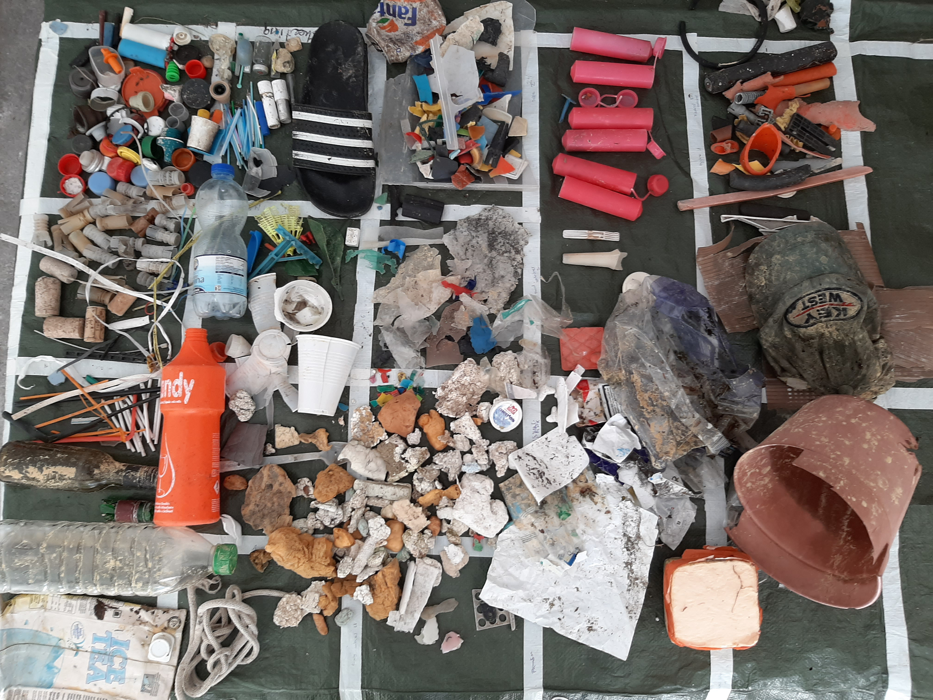

In [2]:
sut.display_image_ipython("resources/images/shared_responsibility/gclosmay2020.jpeg", thumb=(1200, 700))

*__Above: obtaining objective criteria:__. Lac Léman, St. Gingolph 07 May 2020 (15.92pcs/m).*

The utility of discarded objects as well as land use around litter survey sites are indicators of origin. Land use rates to evaluate pollution sources are useful for some common objects. For example, increased quantities of cigarette filters and snack wrappers were identified near sites with a higher concentration of land attributed to buildings and recreation,[_The land use profile_](luseprofile). Objects associated with the consumption of food, drink and tobacco are approximately 26% of all material identified along Swiss shorelines. 

However, other objects have no definitive geographic source nor clear association with an activity in proximity to their location. The most common of these objects are $\approxeq$ 40% of all litter items identified in 2020,  [_Lakes and rivers_ ](allsurveys).    Reducing the amount of litter along Swiss shorelines includes reducing the amount of litter that originates from outside the geographic limits of the beach itself. Thus, an incentive to identify litter objects discarded on or near sites from objects transported to survey locations. 

Obtaining objective beach litter data is complicated by the hydrologic influences of the approximately 61’000km of rivers and 1500 lakes in Switzerland [con].  The hydrologic conditions of rivers have an effect on the distance and direction that litter introduced into a river will travel. Large, low-density objects will most likely be transported to the next reservoir or area of reduced flow. High density objects will only be transported if the flow velocity and turbulence of the water are sufficient to keep the objects off the bottom. Once high-density items enter a low velocity zone they tend to settle or sink {cite}`Schwarz`.

## The origins of the most common objects

The most common objects are the __ten most abundant by quantity AND/OR objects identified in at least 50% of all surveys__. To better understand where these objects originate from, the distinction is made between two groups of objects: 

1. __contributed (CG):__ objects that have multiple positive associations to land use features and one association is to buildings
    * Cigarette ends
    * Metal bottle tops
    * Snack wrappers
    * Glass bottles and pieces   


2. __distributed (DG):__ objects that have few or no positive associations to land use features
    * Fragmented expanded polystyrene
    * Plastic production pellets
    * Fragmented plastics
    * Cotton swabs\*
    * Industrial sheeting
    * Construction plastics

The survey locations are considered in relation to the land-use rates of the surrounding 1500m [_The land use profile_](luseprofile). The median value of the space attributed to buildings was used to differentiate the survey locations into two distinct groups: 

1. __urban:__ locations that have a percent of land attributed to buildings GREATER than the median of all survey locations
2. __rural:__ locations that have a percent of land attributed to buildings LESS than the median of all survey locations AND percent of land attributed to woods or agriculture greater than the median 

The rural class had 148 surveys for 50 locations versus 152 surveys from 34 locations in the urban class. 

__\*Note:__ cotton swabs are included with DG as they are usually introduced directly into a body of water via water treatment facilities. 

*__Below: Identifying DG group items.__ DG is a diverse group of objects representing the construction, manufacturing and agricultural sectors. In some cases, such as fragmented plastics and foamed plastics the original object or utility are undeterminable.*

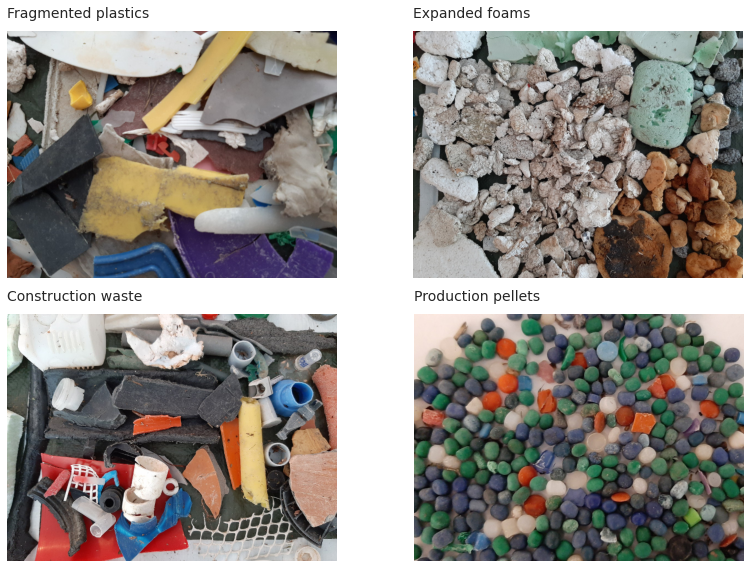

In [3]:
# read images
img_a = mpimg.imread('resources/images/shared_responsibility/fragplass_dense_450_600.jpg')
img_b = mpimg.imread('resources/images/shared_responsibility/fragfoam_450_600.jpg')
img_c = mpimg.imread('resources/images/shared_responsibility/infrastructure_450_600.jpg')
img_d = mpimg.imread('resources/images/shared_responsibility/gpis_450_600.jpg')

# display images
fig, ax = plt.subplots(2,2, figsize=(12,8))

axone=ax[0,0]
sut.hide_spines_ticks_grids(axone)
axone.imshow(img_a);
axone.set_title("Fragmented plastics", **ck.title_k14)

axtwo=ax[0,1]
sut.hide_spines_ticks_grids(axtwo)
axtwo.imshow(img_b);
axtwo.set_title("Expanded foams", **ck.title_k14)

axthree=ax[1,0]
sut.hide_spines_ticks_grids(axthree)
axthree.imshow(img_c);
axthree.set_title("Construction waste", **ck.title_k14)

axfour=ax[1,1]
sut.hide_spines_ticks_grids(axfour)
axfour.imshow(img_d)
axfour.set_title("Production pellets", **ck.title_k14)


plt.tight_layout()
plt.show()

The results from the different groups will be used to test the following null hypothesis, based on the results of Spearmans ranked correlation coefficient: 

If there is no statistically significant evidence that land use features contribute to the accumulation of an object then the distribution of that object should be $\approxeq$ under all land use conditions. 

> Null hypothesis: there is no statistically significant difference between survey results of DG or CG objects at rural and urban locations.

> Alternate hypothesis: there is a statistically significant difference between survey results of DG or CG objects at rural and urban locations.

__methods__

The hypothesis is tested using a combination of non-parametric tests to confirm significance:

1. Two sample Kolmogorov-Smirnov {cite}`ks2sample` 
2. Mann-Whitney *U* (MWU) {cite}`mannwhitney`
3. Bootstrap resampling difference of means {cite}`bcatheory` {cite}`bcaimpdrysdale`

## The data

*__Below:__ Map of survey locations IQAASL.* 

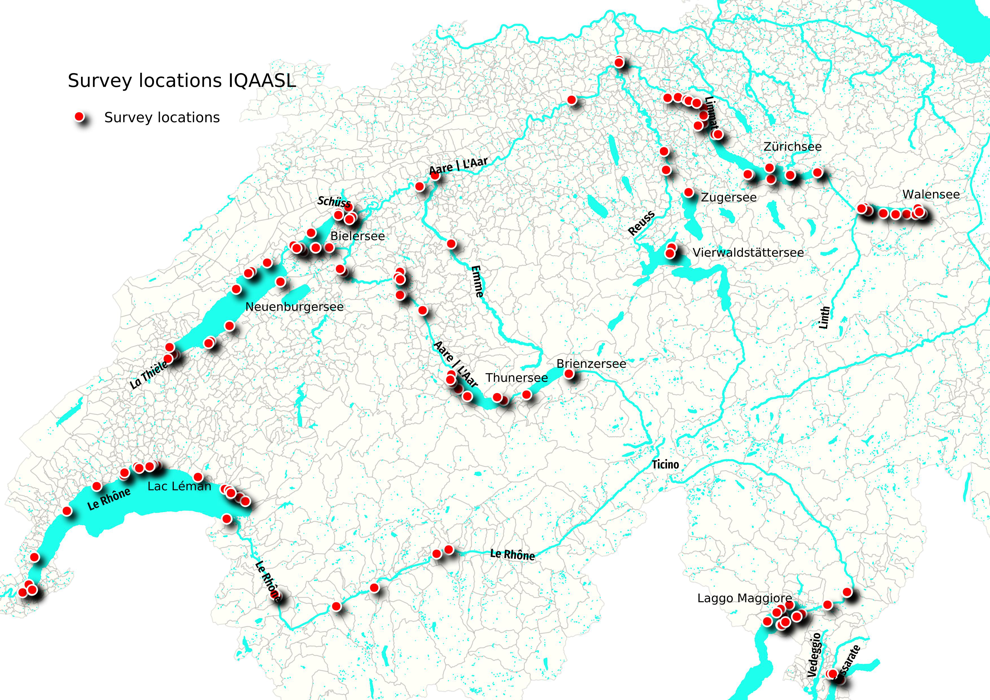

In [4]:
sut.display_image_ipython("resources/maps/survey_locations_all.jpeg", thumb=(1200, 700))

In [5]:
# # make date stamp
survey_data = pd.read_csv('resources/checked_sdata_eos_2020_21.csv')

survey_data["date"] = pd.to_datetime(survey_data["date"])
# survey_data["date"] = survey_data['date'].dt.strftime(g)
# survey_data["date"] = pd.to_datetime(survey_data["date"], format=g)

# the land use data was unvailable for these municipalities
no_land_use = ['Walenstadt', 'Weesen', 'Glarus Nord', 'Quarten']

# slice the data by start and end date, remove the locations with no land use data
use_these_args = ((survey_data["date"] >= start_date)&(survey_data["date"] <= end_date))
survey_data = survey_data[use_these_args].copy()

# slice date to working data
a_data = survey_data[(~survey_data.city.isin(no_land_use))].copy()

# summarize the data
nsamps = a_data.loc_date.nunique()
nlocs = a_data.location.nunique()

# column headers for the survey area data
a_data['survey area'] = a_data.river_bassin.map(lambda x:comp_labels[x])

# feature data
fd = a_data[a_data.w_t == "l"].copy()

# survey totals            
ad_dt = a_data.groupby(['loc_date','location','river_bassin', 'water_name_slug','city','date', 'month', 'eom'], as_index=False).agg({unit_label:'sum', 'quantity':'sum'})

# map survey total quantity to loc_date
fd_dq = ad_dt[['loc_date', 'quantity']].set_index('loc_date')

t = {"locations":fd.location.unique(), "nsamples":fd.loc_date.nunique()}

# gather the dimensional data for the time frame from dfDims
fd_dims= dfDims[(dfDims.location.isin(t["locations"]))&(dfDims.date >= start_date)&(dfDims.date <= end_date)].copy()

# map the survey area name to the dims data record
m_ap_to_survey_area = fd[['location', 'river_bassin']].drop_duplicates().to_dict(orient='records')
a_new_map = {x['location']:x['river_bassin'] for x in m_ap_to_survey_area}

# cumulative statistics for each code
code_totals = sut.the_aggregated_object_values(fd, agg=agg_pcs_median, description_map=code_description_map, material_map=code_material_map)    
most_abundant = code_totals.sort_values(by="quantity", ascending=False)[:10].index

# found greater than 50% of the time
common = code_totals[code_totals['fail rate'] >= 50].index

# the most common
most_common = list(set([*most_abundant, *common]))

# Two land classifications
rural = ["urban", "rural"]

# Two code groups
cgroups = ["DG", "CG"]

DG = "DG"
CG = "CG"

# Two object types
obj_groups = ["FP", "FT"]

# objects that are likely left on site
cont = ["G27", "G30", "G178", "G200"]

# the most common objects minus the objects
# that are most likely left on site
dist = list(set(most_common) - set(cont))

# the survey results are being split according to
# the median value of the selected land use rates
bld_med = fd["% to buildings"].median()
agg_med = fd["% to agg"].median()
wood_med = fd["% to woods"].median()

# rural locations are locations that 
fd['rural'] = ((fd["% to woods"] >= wood_med) | (fd["% to agg"] >= agg_med) ) & (fd["% to buildings"] < bld_med)
fd['rural'] = fd['rural'].where(fd['rural'] == True, 'urban')
fd['rural'] = fd['rural'].where(fd['rural'] == 'urban', 'rural')

# labels for the two groups and a label to catch all the other objects
fd['group'] = 'other'
fd['group'] = fd.group.where(~fd.code.isin(dist), 'DG')
fd['group'] = fd.group.where(~fd.code.isin(cont), 'CG')

# survey totals of all locations with its land use profile (indifferent of land use)
initial = ['loc_date','date','streets', 'intersects']
fd_dt=fd.groupby(initial, as_index=False).agg(agg_pcs_quantity)

# survey totals of contributed and distributed objects, 
second = ['loc_date', 'group', 'rural', 'date','eom', 'river_bassin','location', 'streets', 'intersects']
cg_dg_dt=fd.groupby(second, as_index=False).agg({unit_label:"sum", "quantity":"sum"})

# adding the survey total of all objects to each record
cg_dg_dt['dt']= cg_dg_dt.loc_date.map(lambda x:fd_dq.loc[[x], 'quantity'][0])

# calculating the % total of contributed and distributed at each survey
cg_dg_dt['pt']= cg_dg_dt.quantity/cg_dg_dt.dt

rural = cg_dg_dt[(cg_dg_dt['rural'] == 'rural')].location.unique()
urban = cg_dg_dt[(cg_dg_dt['rural'] == 'urban')].location.unique()
grt_dtr = cg_dg_dt.groupby(['loc_date', 'date','rural'], as_index=False)[unit_label].agg({unit_label:"sum"})

# check the survey totals for each group
astring = F"""
There were {t["nsamples"]} surveys  at {len(t["locations"])} different locations.
"""
md(astring)


There were 300 surveys  at 84 different locations.


In [6]:
# def sieve_eratosthene(limit):

#     primes = [True] * (limit+1)
#     iter = 0

#     while iter < limit**0.5 :
#         if iter < 2:
#             primes[iter]= False

#         elif primes[iter]:
#             for i in range(iter*2, limit+1, iter):
#                 primes[i] = False

#         iter+=1

#     return (str(x) for x in range(limit+1) if primes[x])


# def add_to_this_list(newid):
#     aa = sieve_eratosthene(250000)
    
#     actual = ""
    
#     while len(actual) < newid :
#         newprime = next(aa)
#         newstring = str(newprime)
#         actual += newstring
        
    
#     idlen = 0
#     mynum = ""
    
#     while len(mynum) <5:
#         anum = next(aa)
#         acomp = len(list(anum))
#         needed = 5-idlen
        
#         if needed > acomp:
#             mynum += anum
#         elif needed < acomp:
#             mynum += anum[:acomp - needed]
#         else:
#             pass
#     return mynum
        
# def num_is_valid(x):
#     if x < 0:
#         v = False
#         answer= "Captain lambda requires that all minions have a value  greater than zero"
#     elif x > 10000:
#         v = False
#         answer= "Captain lambda has limited the value of minions to 10,000"
#     else:
#         v = True
#         answer = x   
        
#     return v, answer

# def solution(i):
    
#     v, x = num_is_valid(i)
    
#     if v:        
#         x = add_to_this_list(i)
#         data = int(x[:5])
#     else:
#         data=x
    
#     return  data
    

*Survey results urban and rural locations March 2020 - May 2021. __Left__: Survey totals urban v/s rural, n=300. __Right__: distribution of survey results urban - rural with detail of code-group results.*

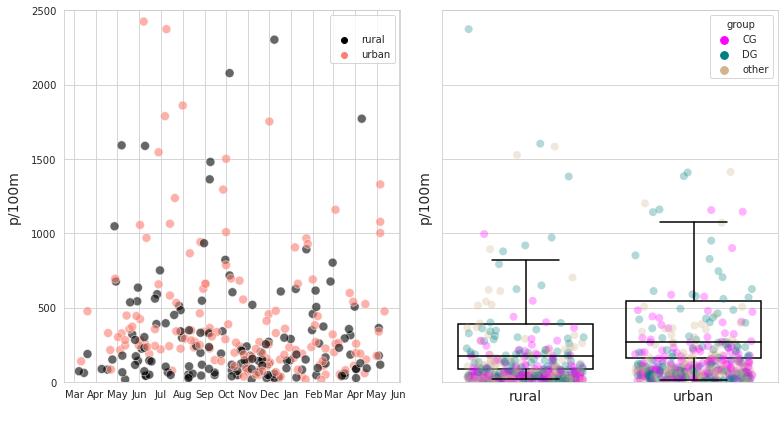

In [7]:
# months locator, can be confusing
# https://matplotlib.org/stable/api/dates_api.html
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter("%b")
days = mdates.DayLocator(interval=7)
fig, axs = plt.subplots(1,2, figsize=(11,6), sharey=True)

group_palette = {'CG':'magenta', 'DG':'teal', 'other':'tan'}
rural_palette = {'rural':'black', 'urban':'salmon' }

ax = axs[0]
sns.scatterplot(data=grt_dtr, x='date', y=unit_label, hue='rural', s=80, palette=rural_palette, alpha=0.6, ax=ax)

ax.set_ylim(0,grt_dtr[unit_label].quantile(.98)+50 )

ax.set_xlabel("")
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)
ax.legend(title=" ")

axtwo = axs[1]

box_props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

sns.boxplot(data=grt_dtr, x='rural', y=unit_label, dodge=False, showfliers=False, ax=axtwo, **box_props)
sns.stripplot(data=cg_dg_dt,x='rural', y=unit_label, ax=axtwo, zorder=1, hue='group', palette=group_palette, jitter=.35, alpha=0.3, s=8)
axtwo.set_ylabel(unit_label, **ck.xlab_k14)

# ax.tick_params(which='both', axis='both', labelsize=0)
axtwo.tick_params(which='both', axis='both', labelsize=14)
axtwo.set_xlabel(" ")

plt.tight_layout()
plt.show()
plt.close()

*Summary data all survey totals*

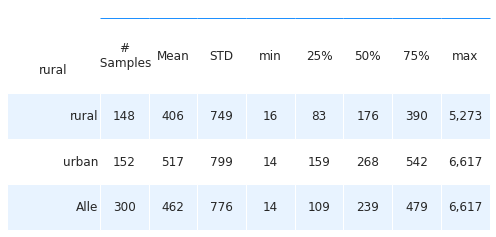

In [8]:
change_names = {"count":"#\n Samples",
                "mean":"Mean",
                "std":"STD", 
                "min":"min",
                "max": "max",
                "25%":"25%",
                "50%":"50%", 
                "75%":"75%",
                "total objects":"Total pieces",
                "# locations":"# locations",
               }

# convenience function to change the index names in a series
def anew_dict(x):
    new_dict = {}
    for param in x.index:
        new_dict.update({change_names[param]:x[param]})
    return new_dict  

# select data
data = grt_dtr

# get the basic statistics from pd.describe
desc_2020 = data.groupby('rural')[unit_label].describe()
desc_2020.loc["Alle", ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']] = grt_dtr.groupby(['loc_date', 'date'])[unit_label].sum().describe().to_numpy()
desc = desc_2020.astype('int')
desc.rename(columns=(change_names), inplace=True)
desc = desc.applymap(lambda x: F"{x:,}")

desc.reset_index(inplace=True)

# make tables
fig, axs = plt.subplots(figsize=(7,3.4))

# summary table
# names for the table columns
a_col = [top_name[0], 'total']

axone = axs
sut.hide_spines_ticks_grids(axone)

a_table = axone.table(cellText=desc.values,  colLabels=desc.columns, colWidths=[.19,*[.1]*8], loc='lower center', bbox=[0,0,1,.95])
the_material_table_data = sut.make_a_summary_table(a_table,desc.values,desc.columns, s_et_bottom_row=False)


plt.tight_layout()
axone.set_xlabel("")
plt.subplots_adjust(wspace=0.2)
plt.show()

*__Above: differences between urban and rural survey totals.__ Survey results in rural locations had a lower median and mean than urban locations and all locations combined. The maximum and the minimum values as well as the highest standard deviation were recorded at urban locations. The 95% confidence intervals of the median value of urban and rural survey results do not overlap, Annex 1.* 

### Assessment of composition: the big picture

The ratio of total DG to total CG in the rural group was 2.5, in the urban group it was 1.6. On a per survey basis, DG was a greater percent of the total in all surveys from rural locations. In urban locations DG and CG compose almost equal portions of the survey total.

> Sample results from rural locations had a greater portion of fragmented plastics, foamed plastics and construction plastics. 

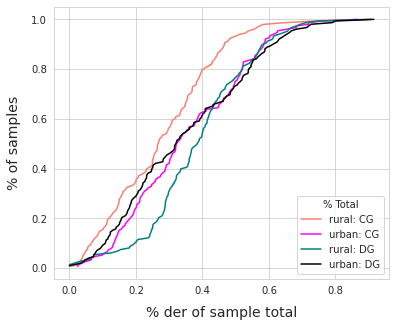

In [9]:
dists = cg_dg_dt[(cg_dg_dt.group == DG)][['loc_date', 'location','rural', unit_label]].set_index('loc_date')
conts = cg_dg_dt[(cg_dg_dt.group == CG)][['loc_date', 'location', 'rural', unit_label]].set_index('loc_date')
conts.rename(columns={unit_label:CG}, inplace=True)
dists.rename(columns={unit_label:DG}, inplace=True)
c_v_d = pd.concat([dists, conts], axis=0)
c_v_d['dt'] = c_v_d[DG]/c_v_d[CG]

# the ratio of dist to cont under the two land use conditions
ratio_of_d_c_agg = c_v_d[c_v_d.rural == 'rural'][DG].sum()/c_v_d[c_v_d.rural == 'rural'][CG].sum()
ratio_of_d_c_urb= c_v_d[c_v_d.rural == 'urban'][DG].sum()/c_v_d[c_v_d.rural == 'urban'][CG].sum()

# chart that
fig, ax = plt.subplots(figsize=(6,5))

# get the eCDF of percent of total for each object group under each condition

# p of t urban
co_agecdf = ECDF(cg_dg_dt[(cg_dg_dt.rural == 'urban')&(cg_dg_dt.group.isin([CG]))]["pt"])
di_agecdf = ECDF(cg_dg_dt[(cg_dg_dt.rural == 'urban')&(cg_dg_dt.group.isin([DG]))]["pt"])

# p of t rural
cont_ecdf = ECDF(cg_dg_dt[(cg_dg_dt.rural == 'rural')&(cg_dg_dt.group.isin([CG]))]["pt"])
dist_ecdf = ECDF(cg_dg_dt[(cg_dg_dt.rural == 'rural')&(cg_dg_dt.group.isin([DG]))]["pt"])

sns.lineplot(x=cont_ecdf.x, y=cont_ecdf.y, color='salmon', label="rural: CG", ax=ax)
sns.lineplot(x=co_agecdf.x, y=co_agecdf.y, color='magenta', ax=ax, label="urban: CG")
sns.lineplot(x=dist_ecdf.x, y=dist_ecdf.y, color='teal', label="rural: DG", ax=ax)
sns.lineplot(x=di_agecdf.x, y=di_agecdf.y, color='black', label="urban: DG", ax=ax)

ax.set_xlabel("% der of sample total", **ck.xlab_k14)
ax.set_ylabel("% of samples", **ck.xlab_k14)
plt.legend(loc='lower right', title="% Total")

plt.show()

### Distribution of survey totals for the different object groups

The survey results of the DG are very similar under both land use classes, there is more variance as the reported value increases but not so much that the distributions diverge. Given the standard deviation of the samples and the high variance of beach-litter-survey data in general this is expected. {cite}`eubaselines`

The two sample Kolmogorov-Smirnov (KS) tests (ks=0.073, p=0.808) of the two sets of survey results suggest that the survey results of DG may not be significantly different between the two land use classes. The results from the Mann-Whitney U (MWU) (U=11445.0, p=0.762) suggest that it is possible that the two distributions are the same

*__Below:__ empirical cumulative distribution (eCDF) of DG and CG. __Left:__ recall that DG objects included fragmented plastics, fragmented foams, construction plastics and production pellets. __Right:__  the survey results for cigarette ends and snack wrappers have visually distinct distributions under the two land use conditions.*

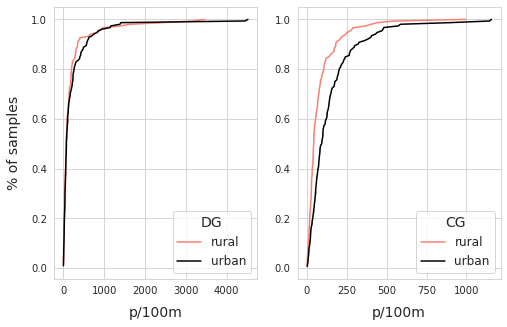

In [10]:
# the dg group objects evaluated at rural locations
d_r_a = cg_dg_dt[(cg_dg_dt.rural == 'rural')&(cg_dg_dt.group == DG)].groupby(['loc_date', 'group'])[unit_label].sum()
dist_results_agg = d_r_a.values
a_d_ecdf = ECDF(dist_results_agg )

# the dg objects evaluated at urban locations
d_r_u = cg_dg_dt[(cg_dg_dt.rural == 'urban')&(cg_dg_dt.group == DG)].groupby(['loc_date', 'group'])[unit_label].sum()
dist_results_urb = d_r_u.values
b_d_ecdf = ECDF(dist_results_urb )

# the CG objects evaluated at rural locations
c_r_a = cg_dg_dt[(cg_dg_dt.rural == 'rural')&(cg_dg_dt.group == CG)].groupby('loc_date')[unit_label].sum()
cont_results_agg = c_r_a.values
a_d_ecdf_cont = ECDF(cont_results_agg)

# the CG objects evaluated at urban locations
c_r_u = cg_dg_dt[(cg_dg_dt.rural == 'urban')&(cg_dg_dt.group == CG)].groupby('loc_date')[unit_label].sum()
cont_results_urb = c_r_u.values
b_d_ecdf_cont = ECDF(cont_results_urb)

fig, ax = plt.subplots(1,2, figsize=(8,5))

axone = ax[0]
sns.lineplot(x=a_d_ecdf.x, y=a_d_ecdf.y, color='salmon', label="rural", ax=axone)
sns.lineplot(x=b_d_ecdf.x, y=b_d_ecdf.y, color='black', label="urban", ax=axone)
axone.set_xlabel(unit_label, **ck.xlab_k14)
axone.set_ylabel("% of samples", **ck.xlab_k14)
axone.legend(fontsize=12, title=DG,title_fontsize=14)


axtwo = ax[1]
sns.lineplot(x=a_d_ecdf_cont.x, y=a_d_ecdf_cont.y, color='salmon', label="rural", ax=axtwo)
sns.lineplot(x=b_d_ecdf_cont.x, y=b_d_ecdf_cont.y, color='black', label="urban", ax=axtwo)

axtwo.set_xlabel(unit_label, **ck.xlab_k14)
axtwo.set_ylabel(' ')
axtwo.legend(fontsize=12, title=CG,title_fontsize=14)

plt.show()

According to the KS test (rho=0.09, p=0.48) there is no statistical reason to assume that more DG objects are found under the difference land use conditions, according to the MWU test (MWU=1039, p=0.25) there is a chance that the incidence of DG objects is the same indifferent of the land use profile. On the other hand the CG survey results diverge almost immediately and results of the KS test (rho=0.31, p<.001) and MWU (MWU=7305, p<.001) suggest that the distribution of these objects is associated with % of land attributed to buildings. 

#### Difference of means

The average survey result of DG objects in rural locations was 202p/100m as opposed to 237p/100m at urban locations, a difference of -35p/100m is just a small fraction of the standard deviation. A permutation test on the difference of means was conducted on the condition rural - urban of the mean of survey data.  

*Difference of means DG objects. $\mu_{rural}$ - $\mu_{urban}$, method=shuffle, permutations=5000.*

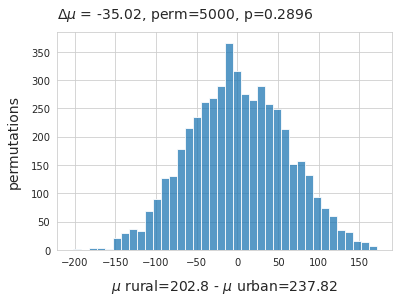

In [11]:
# for display purposes: the results of the ks and MWU tests for DG objects
# print(stats.ks_2samp(dist_results_agg, dist_results_urb, alternative='two-sided', mode='auto'))
# print(stats.mannwhitneyu(dist_results_agg,dist_results_urb, alternative='two-sided'))

# for display purposes: the results of the ks and MWU tests for CG objects
# print(stats.ks_2samp(cont_results_agg, cont_results_urb, alternative='two-sided', mode='auto'))
# print(stats.mannwhitneyu(cont_results_agg, cont_results_urb, alternative='two-sided'))

# combine the DG results from both land use classess
agdg = pd.DataFrame(d_r_a.copy())
budg = pd.DataFrame(d_r_u.copy())

# label the urban and rural results
agdg["class"] = 'rural'
budg['class'] = 'urban'

# merge into one 
dg_merg = pd.concat([agdg, budg], axis=0)

# store the mean per class
the_mean = dg_merg.groupby('class')[unit_label].mean()

# store the difference
mean_diff = the_mean.loc['rural'] - the_mean.loc['urban']
new_means=[]
# permutation resampling:
for element in np.arange(5000):
    dg_merg['new_class'] = dg_merg['class'].sample(frac=1).values
    b=dg_merg.groupby('new_class').mean()
    new_means.append((b.loc['rural'] - b.loc['urban']).values[0])
emp_p = np.count_nonzero(new_means <= (the_mean.loc['rural'] - the_mean.loc['urban'])) / 5000

# chart the results
fig, ax = plt.subplots()

sns.histplot(new_means, ax=ax)
ax.set_title(F"$\u0394\mu$ = {np.round(mean_diff, 2)}, perm=5000, p={emp_p} ", **ck.title_k14)
ax.set_ylabel('permutations', **ck.xlab_k14)
ax.set_xlabel(f"$\mu$ rural={np.round(the_mean.loc['rural'], 2)} - $\mu$ urban={np.round(the_mean.loc['urban'], 2)}", **ck.xlab_k14)
plt.show()

*__Above:__ refuse to reject the null hypothesis that these two distributions may be the same. The observed difference of means falls within the 95% interval of the bootstrap results.*

## Conclusion

A positive statistically relevant association between CG objects and land use attributed to infrastructure such as streets, recreation areas and buildings can be assumed. Representing 4/12 most common objects, approximately 26% of all objects identified and can be associated to activities within 1500m of the survey location. 

In contrast the DG group has an $\approxeq$ distribution under the different land use classes and no association to the percent of land attributed to buildings. Composed of construction plastics, fragmented foamed plastics, plastic pieces and industrial pellets the DG represents a diverse group of objects with different densities. With no statistical evidence to the contrary the null hypothesis cannot be rejected. Therefore, it cannot be assumed that the primary source was within 1500m of the survey location and it is likely a portion of these objects have origins upstream (economically and geographically). 

*__Below:__ Establishing objective criteria. Identifying and quantifying objects collected from a litter survey may be done on site, if the weather permits. The dimensional data and initial inventory are documented in a notebook and then entered in to the app [The litter surveyor](https://www.plagespropres.ch).     Objects of interest: plastic shotgun wadding, agricultural fencing and tile spacer.* 

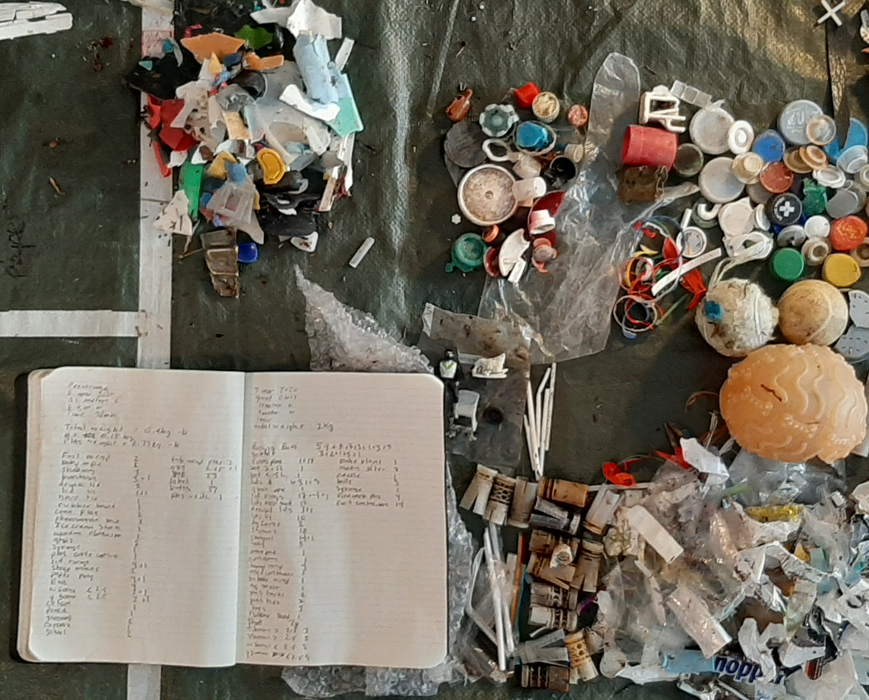

In [12]:
sut.display_image_ipython("resources/images/baselines/takingnotes.jpg", thumb=(1200, 700))

### Discussion

By comparing the survey results to the independent variables around the survey locations a numerical representation can be established that describes how likely the object was discarded where it was found. The association established numerically is reinforced by daily experience. For example, a portion of cigarettes and snacks are likely consumed on or near sites where sold and some of the associated material may escape into the environment. 

Some distinctive objects used by relatively small portions of the economy may be identified throughout a region but confined to zones of accumulation due to hydrologic transport making it difficult to identify the source. 

However, the previous example shows that survey results increase or decrease in response to explanatory variables. For objects such as plastic pre- production pellets (GPI) the use case of the item is definite and users and producers are relatively rare with respect to other litter items. Even though these objects are found in all survey areas it is unlikely that they are emitted at equal rates. 

Given the previous example it is possible to follow the increasing survey results of GPI on two different lakes to understand how this relationship can be visualized.  

*__Below:__ The increase in the median p/100m as surveys approach the upstream source. GPIs are small and difficult to clean up once they have been spilled making the exact source difficult to determine. However, it is reasonable to assume that the handlers and consumers of GPIs will have best insight on preventing material loss into the environment. The probability of finding at least one is double the regional rate at some of the locations below.*

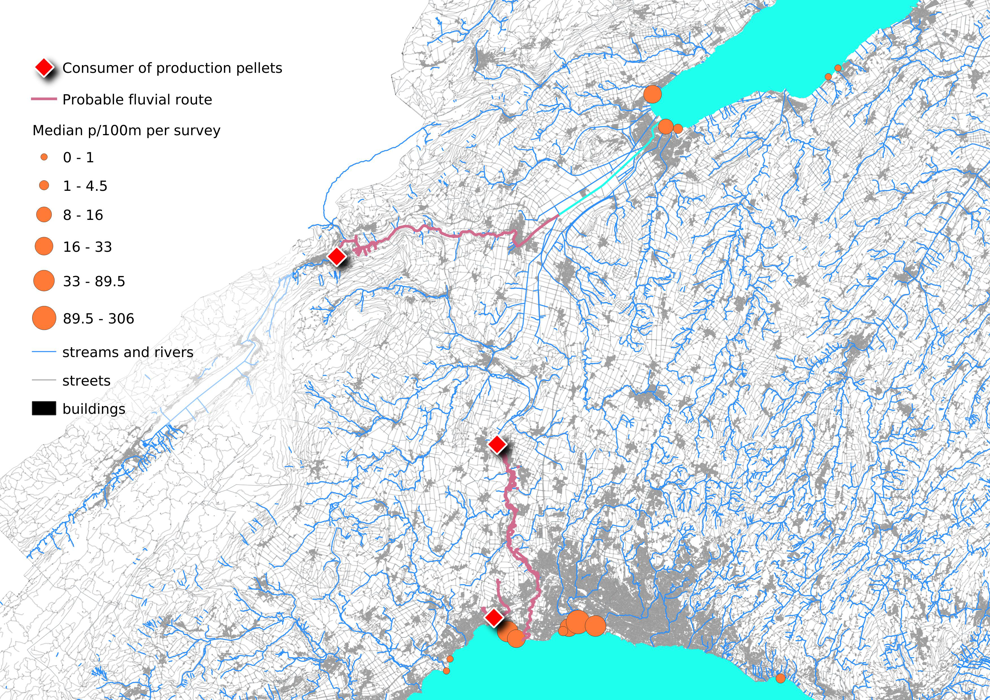

In [13]:
sut.display_image_ipython("resources/images/shared_responsibility/causality.jpeg", thumb=(1200, 700))

#### Finding partners

The results from the test indicate that CG objects are more prevalent in urban locations. Urban was defined as the land use within 1500m of the survey area. From this it is safe to assume that the cause(s) of CG group litter are also more prevalent in urban areas and that the secondary cause of the litter is within 1500m of the survey location. 

Stakeholders looking to reduce the incidence of CG objects within a specific zone may have a better chance of finding motivated partners within 1500m of the location of concern. 

The DG group has the particularity that it is distributed in $\approxeq$ rates indifferent of the land use and it makes up a larger proportion of the objects found than CG. This implies that the solution is at a larger scale than the municipal boundaries. 

Fragmented plastics is the only DG object on the list that cannot be attributed to at least one industry that is present in all the survey areas covered by this analysis. 

* Expanded polystyrene is used as an exterior insulation envelope in the construction industry and is used as packaging to protect fragile objects during transport. 
* Plastic pre-production pellets are used to make plastic objects in the injection molding process. 
* Plastic cotton swab sticks are often diverted to rivers and lakes via water treatment plants. 
* Industrial sheeting is used in agriculture, transport and construction industries.  
* Construction plastics

Finding partners for these objects may involve an initial phase of informative targeted communication using the IQAASL results and current EU thresholds and baselines for beach litter {cite}`eubaselines`.

#### Sharing the responsibility

The principle of Extended Producer Responsibility (EPR) may provide the incentive to producers and consumers to account for the real costs of end-of-life management of the most common litter items identified in Switzerland. {cite}`poulki`

A recent study in the Marine Policy journal identified several limitations of using preexisting beach litter survey data to assess the impact of EPR policy on observed litter quantities. {cite}`HARRIS2021104319`

1. Limited data
2. Heterogeneous methods
3. Data not collected for the purposes of evaluating ERP

To correct these limitations the authors provide the following recommendations:

1. Create a data framework specifically for monitoring ERP targets
2. Identify sources 
3. Use litter counts to establish baselines
4. Frequent monitoring

Litter counts mitigate the effects of light-weight packaging when collection results are based on weights. {cite}`HARRIS2021104319`

The IQAASl project addresses three out of the four recommendations and it introduced a method that allows stakeholders to add specific items to the survey protocol. Thus monitoring progress towards ERP targets can be implemented as long as the objects can be defined visually and can be counted.

The current database of beach-litter surveys in Switzerland includes over 1,000 samples collected using the same protocol in the past six years. Switzerland has all the elements in place to accurately estimate minimum probable values for the most common objects and evaluate stochastic. This report offers several ways to evaluate differences between survey results, others should be considered as well. 

This report offers several different ways to evaluate differences between survey results, there are certainly others that should be considered. There are many improvements to be made concerning the national strategy:

A national strategy should include:

* Define a standardized reporting method for municipal, cantonal and federal stakeholders 
* Define monitoring or assessment goals 
* Formalize the data repository and the method for implementation at different administrative levels 
* Develop a network of associations that share the responsibility and resources for surveying the territory 
* Develop and implement a formal training program for surveyors that includes data science, and GIS technologies 
* Determine, in collaboration with academic partners, ideal sampling scenarios and research needs 
* Develop a financing method to ensure that enough samples are collected per year per region to accurately assess conditions and research requirements are met 

## Annex

Organizations that collected samples

1. Precious plastic leman
2. Association pour la sauvetage du Léman
3. Geneva international School
4. Solid waste management: École polytechnique fédérale Lausanne
5. Hamerdirt
6. Hackuarium
7. WWF Switzerland


### Results of Speramans ranked correlation test

An association is a relationship between the survey results and the land use profile that is unlikely due to chance. The magnitude of the relationship is neither defined nor linear. 

Ranked correlation is a non-parametric test to determine if there is a statistically significant relationship between land use and the objects identified in a litter survey. 

The method used is the Spearman’s rho or Spearmans ranked correlation coefficient. The test results are evaluated at p<0.05 for all valid lake samples in the survey area. 

1. Red/rose is a positive association
2. Yellow is a negative association
3. White means that p>0.05, there is no statistical basis to assume an association

*__Below:__ Ranked association of the most common objects with land use characteristics.* 

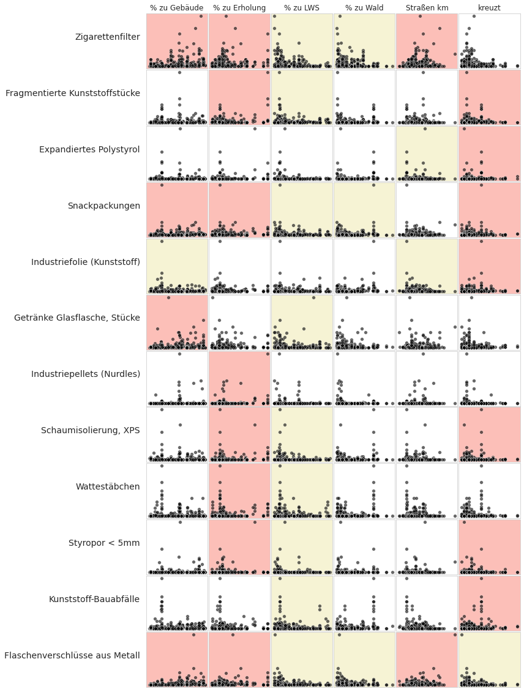

In [14]:
sut.display_image_ipython("resources/images/shared_responsibility/land_use_correlation_de_30_0.png", thumb=(1200, 700))

*__Below:__ 95% confidence interval of the median survey value under the different land use classes.* 

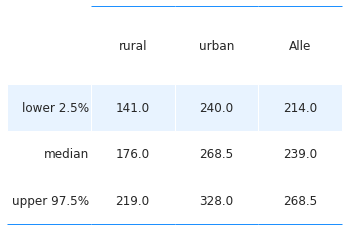

In [15]:
# this code was modified from this source:
# http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2019a/content/recitations/bootstrapping.html
# if you want to get the confidence interval around another point estimate use np.percentile
# and add the percentile value as a parameter

def draw_bs_sample(data):
    """Draw a bootstrap sample from a 1D data set."""
    return np.random.choice(data, size=len(data))

def compute_jackknife_reps(data, statfunction=None, stat_param=False):
    '''Returns jackknife resampled replicates for the given data and statistical function'''
    # Set up empty array to store jackknife replicates
    jack_reps = np.empty(len(data))

    # For each observation in the dataset, compute the statistical function on the sample
    # with that observation removed
    for i in range(len(data)):
        jack_sample = np.delete(data, i)
        if not stat_param:
            jack_reps[i] = statfunction(jack_sample)
        else:
            jack_reps[i] = statfunction(jack_sample, stat_param)          
        
    return jack_reps


def compute_a(jack_reps):
    '''Returns the acceleration constant a'''

    mean = np.mean(jack_reps)
    try:
        a = sum([(x**-(i+1)- (mean**-(i+1)))**3 for i,x in enumerate(jack_reps)])
        b = sum([(x**-(i+1)-mean-(i+1))**2 for i,x in enumerate(jack_reps)])
        c = 6*(b**(3/2))
        data = a/c
    except:
        print(mean)
    return data


def bootstrap_replicates(data, n_reps=1000, statfunction=None, stat_param=False):
    '''Computes n_reps number of bootstrap replicates for given data and statistical function'''
    boot_reps = np.empty(n_reps)
    for i in range(n_reps):
        if not stat_param:
            boot_reps[i] = statfunction(draw_bs_sample(data))
        else:
            boot_reps[i] = statfunction(draw_bs_sample(data), stat_param)     
        
    return boot_reps


def compute_z0(data, boot_reps, statfunction=None, stat_param=False):
    '''Computes z0 for given data and statistical function'''
    if not stat_param:
        s = statfunction(data)
    else:
        s = statfunction(data, stat_param)
    return stats.norm.ppf(np.sum(boot_reps < s) / len(boot_reps))


def compute_bca_ci(data, alpha_level, n_reps=1000, statfunction=None, stat_param=False):
    '''Returns BCa confidence interval for given data at given alpha level'''
    # Compute bootstrap and jackknife replicates
    boot_reps = bootstrap_replicates(data, n_reps, statfunction=statfunction, stat_param=stat_param)
    jack_reps = compute_jackknife_reps(data, statfunction=statfunction, stat_param=stat_param)

    # Compute a and z0
    a = compute_a(jack_reps)
    z0 = compute_z0(data, boot_reps, statfunction=statfunction, stat_param=stat_param)

    # Compute confidence interval indices
    alphas = np.array([alpha_level/2., 1-alpha_level/2.])
    zs = z0 + stats.norm.ppf(alphas).reshape(alphas.shape+(1,)*z0.ndim)
    avals = stats.norm.cdf(z0 + zs/(1-a*zs))
    ints = np.round((len(boot_reps)-1)*avals)
    ints = np.nan_to_num(ints).astype('int')

    # Compute confidence interval
    boot_reps = np.sort(boot_reps)
    ci_low = boot_reps[ints[0]]
    ci_high = boot_reps[ints[1]]
    return (ci_low, ci_high)


the_bcas = {}

an_int = 50

# rural cis
r_median = grt_dtr[grt_dtr.rural == 'rural'][unit_label].median()
a_result = compute_bca_ci(grt_dtr[grt_dtr.rural == 'rural'][unit_label].to_numpy(), .05, n_reps=5000, statfunction=np.percentile, stat_param=an_int)
r_cis = {'rural':{"lower 2.5%":a_result[0], "median":r_median, "upper 97.5%": a_result[1] }}
the_bcas.update(r_cis)

# urban cis
u_median = grt_dtr[grt_dtr.rural == 'urban'][unit_label].median()
a_result = compute_bca_ci(grt_dtr[grt_dtr.rural == 'urban'][unit_label].to_numpy(), .05, n_reps=5000, statfunction=np.percentile, stat_param=an_int)
u_cis = {'urban':{"lower 2.5%":a_result[0], "median":u_median, "upper 97.5%": a_result[1] }}
the_bcas.update(u_cis)

# all surveys
u_median = grt_dtr[unit_label].median()
a_result = compute_bca_ci(grt_dtr[unit_label].to_numpy(), .05, n_reps=5000, statfunction=np.percentile, stat_param=an_int)
all_cis = {"Alle":{"lower 2.5%":a_result[0], "median":u_median, "upper 97.5%": a_result[1] }}

# combine the results:
the_bcas.update(all_cis)

# make a df
the_cis = pd.DataFrame(the_bcas)
the_cis.reset_index(inplace=True)

fig, axs = plt.subplots()

data = the_cis.values
collabels = the_cis.columns
sut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(data, colLabels=collabels, colWidths=[*[.2]*5], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data,collabels, a_color, s_et_bottom_row=True)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.close()


*__Below:__ the survey results of the most common objects under the two different land use classes.*

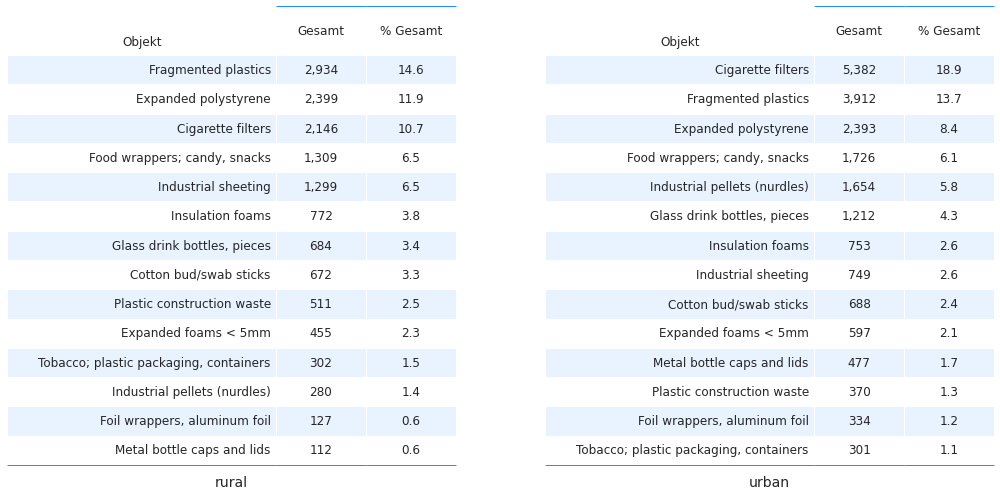

In [16]:
rur_10 = fd[(fd.rural == 'rural')&(fd.code.isin(most_common))].groupby('code', as_index=False).quantity.sum().sort_values(by='quantity', ascending=False)
urb_10 = fd[(fd.rural == 'urban')&(fd.code.isin(most_common))].groupby('code', as_index=False).quantity.sum().sort_values(by='quantity', ascending=False)

rur_tot = fd[fd.location.isin(rural)].quantity.sum()
urb_tot = fd[fd.location.isin(urban)].quantity.sum()

rur_10['item'] = rur_10.code.map(lambda x: code_description_map.loc[x])
urb_10['item'] = urb_10.code.map(lambda x: code_description_map.loc[x])

rur_10["% of total"] = ((rur_10.quantity/rur_tot)*100).round(1)
urb_10["% of total"] = ((urb_10.quantity/urb_tot)*100).round(1)

# make tables
fig, axs = plt.subplots(1, 2, figsize=(14,len(most_common)*.5))

# summary table
# names for the table columns
a_col = [top_name[0], 'total']

axone = axs[0]
axtwo = axs[1]

sut.hide_spines_ticks_grids(axone)
sut.hide_spines_ticks_grids(axtwo)
new_col_names = {"item":"Objekt","quantity":"Gesamt", "% of total":"% Gesamt"}
data_one = rur_10[['item', 'quantity', "% of total"]].copy()
data_one.rename(columns=new_col_names, inplace=True)
data_two = urb_10[['item', 'quantity', "% of total"]].copy()
data_two.rename(columns=new_col_names, inplace=True)

for a_df in [data_one, data_two]:
    a_df["Gesamt"] = a_df["Gesamt"].map(lambda x: F"{x:,}")

a_table = axone.table(cellText=data_one.values,  colLabels=data_one.columns, colWidths=[.6,*[.2]*2], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,data_one.values,data_one.columns, s_et_bottom_row=True)

a_table = axtwo.table(cellText=data_two.values,  colLabels=data_one.columns, colWidths=[.6,*[.2]*2], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,data_one.values,data_one.columns, s_et_bottom_row=True)

axone.set_xlabel("rural", **ck.xlab_k14)
axtwo.set_xlabel("urban", **ck.xlab_k14)
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()

### Seasonal variations

Seasonal variations of beach litter survey results have been documented under varying conditions and environments. In 2018 the SLR  {cite}`slr`  reported the maximum value in July and the minimum in November. The year 2020-2021 presents the same results.

*__Below:__ monthly survey results and river discharge rates m³/second*

*April and May 2021 are rolling averages, data not available*

*source : https://www.hydrodaten.admin.ch/en/stations-and-data.html?entrance_medium=menu*

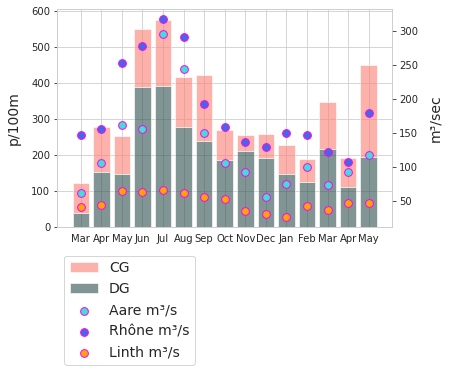

In [17]:
# the survey results to test
corr_data = fd[(fd.code.isin(most_common))].copy()
results_sprmns = {}
for i,code in enumerate(most_common):
    data = corr_data[corr_data.code == code]
    for j, n in enumerate(luse_exp):
        corr, a_p = stats.spearmanr(data[n], data[unit_label])
        results_sprmns.update({code:{"rho":corr, 'p':a_p}})

# helper dict for converting ints to months
months={
    0:'Jan',
    1:'Feb',
    2:'Mar',
    3:'Apr',
    4:'May',
    5:'Jun',
    6:'Jul',
    7:'Aug',
    8:'Sep',
    9:'Oct',
    10:'Nov',
    11:'Dec'
}

m_dt = fd.groupby(['loc_date', 'date','group'], as_index=False).agg({'quantity':'sum', unit_label:'sum'})

# sample totals all objects
m_dt_t = fd.groupby(['loc_date','date','month', 'eom'], as_index=False).agg({unit_label:'sum'})
m_dt_t.set_index('date', inplace=True)

# data montlhy median survey results contributed, distributed and survey total
fxi=m_dt.set_index('date', drop=True)
data1 = fxi[fxi.group == CG][unit_label].resample("M").mean()
data2 = fxi[fxi.group == DG][unit_label].resample("M").mean()

# helper tool for months in integer order
def new_month(x):
    if x <= 11:
        this_month = x
    else:
        this_month=x-12    
    return this_month

# the monthly average discharge rate of the three rivers where the majority of the samples are
aare_schonau = [61.9, 53, 61.5, 105, 161, 155, 295, 244, 150, 106, 93, 55.2, 74.6, 100, 73.6, 92.1]
rhone_scex =   [152, 144, 146, 155, 253, 277, 317, 291, 193, 158, 137, 129, 150, 146, 121, 107]
linth_weesen = [25.3, 50.7, 40.3, 44.3, 64.5, 63.2, 66.2, 61.5, 55.9, 52.5, 35.2, 30.5, 26.1, 42.0, 36.9]

fig, ax = plt.subplots()
    
this_x = [i for i,x in  enumerate(data1.index)]
this_month = [x.month for i,x in enumerate(data1.index)]

twin_ax = ax.twinx()
twin_ax.grid(None)

ax.bar(this_x, data1.to_numpy(), label='CG', bottom=data2.to_numpy(), linewidth=1, color="salmon", alpha=0.6)
ax.bar([i for i,x in  enumerate(data2.index)], data2.to_numpy(), label='DG', linewidth=1,color="darkslategray", alpha=0.6)

sns.scatterplot(x=this_x,y=[*aare_schonau[2:], np.mean(aare_schonau)], color='turquoise',  edgecolor='magenta', linewidth=1, s=60, label='Aare m³/s', ax=twin_ax)
sns.scatterplot(x=this_x,y=[*rhone_scex[2:], np.mean(rhone_scex)], color='royalblue',  edgecolor='magenta', linewidth=1, s=60, label='Rhône m³/s', ax=twin_ax)
sns.scatterplot(x=this_x,y=[*linth_weesen[2:], np.mean(linth_weesen), np.mean(linth_weesen)], color='orange', edgecolor='magenta', linewidth=1, s=60, label='Linth m³/s', ax=twin_ax)
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = twin_ax.get_legend_handles_labels()
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))

ax.set_ylabel(unit_label, **ck.xlab_k14)
twin_ax.set_ylabel("m³/sec", **ck.xlab_k14)

axisticks = ax.get_xticks()
labelsx = [months[new_month(x-1)] for x in  this_month]

plt.xticks(ticks=axisticks, labels=labelsx)
plt.legend([*handles, *handles2], [*labels, *labels2], bbox_to_anchor=(0,-.1), loc='upper left', fontsize=14)

plt.show()

## The survey results of FP and FT with respect to land use


__Results of KS test and Mann Whitney U__

The survey results for FP objects are very similar up to $\approxeq$ the 85th percentile where the rural survey results are noticeably larger. Suggesting that extreme values for FP were more likely in rural locations. According to the KS test (ks=0.78, pvalue=0.69) and MWU test (U=10624, pvalue=0.40) the distribution of FP objects under the two land use classes is not significantly different and may be equal. 

The survey results for FT objects maintain the same features as the parent distribution. The results of the KS test (ks=0.29, pvalue<.001) and MWU test (U=7356.5, p<.001) agree with the results of the parent group, that there is a statistically relevant difference between the survey results under different land use classes. 

*__Below left rural - urban:__ ECDF of survey results fragmented plastics and foams (FP). __Below right rural - urban:__ ECDF of survey results cigarette ends and candy wrappers (FT)*

*__Left:__ rural - urban: ECDF of survey results fragmented plastics and foams (FP)*

*__Right:__ rural - urban: ECDF of survey results cigarette ends and candy wrappers (FT)*

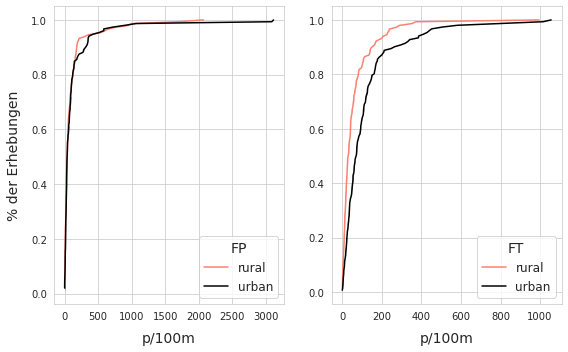

In [18]:
agg_dobj = fd[(fd.rural == 'rural')&(fd.code.isin(['Gfrags', 'Gfoam']))].groupby(['loc_date'])[unit_label].sum().values
buld_obj = fd[(fd.rural == 'urban')&(fd.code.isin(['Gfrags', 'Gfoam']))].groupby(['loc_date'])[unit_label].sum().values

a_d_ecdf = ECDF(agg_dobj)
b_d_ecdf = ECDF(buld_obj)

agg_cont = fd[(fd.rural == 'rural')&(fd.code.isin(['G27', 'G30']))].groupby(['loc_date'])[unit_label].sum().values
b_cont = fd[(fd.rural == 'urban')&(fd.code.isin(['G27', 'G30']))].groupby(['loc_date'])[unit_label].sum().values

a_c_ecdf = ECDF(agg_cont)
b_c_ecdf = ECDF(b_cont)

fig, ax = plt.subplots(1,2, figsize=(8,5))

axone = ax[0]
sns.lineplot(x=a_d_ecdf.x, y=a_d_ecdf.y, color='salmon', label="rural", ax=axone)
sns.lineplot(x=b_d_ecdf.x, y=b_d_ecdf.y, color='black', label="urban", ax=axone)
axone.set_xlabel(unit_label, **ck.xlab_k14)
axone.set_ylabel('% der Erhebungen', **ck.xlab_k14)

axone.legend(fontsize=12, title='FP',title_fontsize=14)

axtwo = ax[1]
sns.lineplot(x=a_c_ecdf.x, y=a_c_ecdf.y, color='salmon', label="rural", ax=axtwo)
sns.lineplot(x=b_c_ecdf.x, y=b_c_ecdf.y, color='black', label="urban", ax=axtwo)

axtwo.set_xlabel(unit_label, **ck.xlab_k14)
axtwo.set_ylabel(' ')

axtwo.legend(fontsize=12, title='FT',title_fontsize=14)

plt.tight_layout()

plt.show()

### FP and FT difference of means.

The average survey result of FP objects in rural locations was 22.93p/50m in urban locations it was 12p/50m. A permutation test on the difference of means was conducted on the condition *rural* - *urban*.

*__Below:__ Difference of means fragmented foams and plastics under the two different land use classes.*

*$\mu_{rural}$ - $\mu_{urban}$, method=shuffle, permutations=5000*

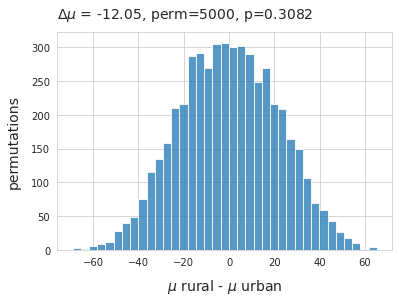

In [19]:
# pemutation test: of difference of means FP objects
agg_dobj = fd[(fd.rural == 'rural')&(fd.code.isin(['Gfrags', 'G89']))].groupby(['loc_date'], as_index=False)[unit_label].sum()
buld_obj = fd[(fd.rural == 'urban')&(fd.code.isin(['Gfrags', 'G89']))].groupby(['loc_date'], as_index=False)[unit_label].sum()
# label the urban and rural results
agg_dobj['class'] = 'rural'
buld_obj['class'] = 'urban'

# merge into one 
objs_merged = agg_dobj.append(buld_obj)

# store the mean per class
the_mean = objs_merged.groupby('class')[unit_label].mean()

# store the difference
mean_diff = the_mean.loc['rural'] - the_mean.loc['urban']
new_means=[]

# permutation resampling:
for element in np.arange(5000):
    objs_merged['new_class'] = objs_merged['class'].sample(frac=1).values
    b=objs_merged.groupby('new_class').mean()
    new_means.append((b.loc['rural'] - b.loc['urban']).values[0])
emp_p = np.count_nonzero(new_means <= (the_mean.loc['rural'] - the_mean.loc['urban'])) / 5000

# chart the results
fig, ax = plt.subplots()

sns.histplot(new_means, ax=ax)
ax.set_title(F"$\u0394\mu$ = {np.round(mean_diff, 2)}, perm=5000, p={emp_p} ", **ck.title_k14)
ax.set_ylabel('permutations', **ck.xlab_k14)
ax.set_xlabel("$\mu$ rural - $\mu$ urban", **ck.xlab_k14)
plt.show()

*__Above:__ Refuse to reject the null hypotheses: there is no statistically significant difference between the two distributions* 

*__Below:__ Difference of means cigarette ends and snack wrappers under the two different land use classes.*

*$\mu_{rural}$ - $\mu_{urban}$, method=shuffle, permutations=5000*

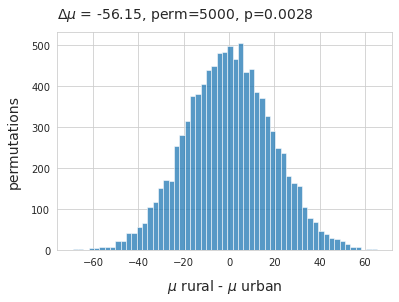

In [20]:
# pemutation test: of difference of means food objects
agg_cont = fd[(fd.rural == 'rural')&(fd.code.isin(['G27', 'G30']))].groupby(['loc_date'], as_index=False)[unit_label].sum()
b_cont = fd[(fd.rural == 'urban')&(fd.code.isin(['G27', 'G30']))].groupby(['loc_date'], as_index=False)[unit_label].sum()
# label the urban and rural results
agg_cont['class'] = 'rural'
b_cont['class'] = 'urban'

# merge into one 
objs_merged = agg_cont.append(b_cont)

# store the mean per class
the_mean = objs_merged.groupby('class')[unit_label].mean()

# store the difference
mean_diff = the_mean.loc['rural'] - the_mean.loc['urban']

# permutation resampling:
for element in np.arange(5000):
    objs_merged['new_class'] = objs_merged['class'].sample(frac=1).values
    b=objs_merged.groupby('new_class').mean()
    new_means.append((b.loc['rural'] - b.loc['urban']).values[0])
emp_p = np.count_nonzero(new_means <= (the_mean.loc['rural'] - the_mean.loc['urban'])) / 5000

# chart the results
fig, ax = plt.subplots()

sns.histplot(new_means, ax=ax)
ax.set_title(F"$\u0394\mu$ = {np.round(mean_diff, 2)}, perm=5000, p={emp_p} ", **ck.title_k14)
ax.set_ylabel('permutations', **ck.xlab_k14)
ax.set_xlabel("$\mu$ rural - $\mu$ urban", **ck.xlab_k14)
plt.show()

*__Above:__ Reject the null hypothesis: the two distributions are most likely not the same*

In [21]:
# a set of map points with the median survey value for each of the most 
# common codes and median survey value of DG and CG
a_maps = fd[(fd.code.isin(most_common))].groupby(['loc_date','location', 'code'], as_index=False)[unit_label].sum()

# median survey result for each code at each location
a_map = a_maps.groupby(['location', 'code'], as_index=False)[unit_label].median()

# pivot that and get codes as columns
som_vals = a_map.pivot(columns=['code'], index='location', values=unit_label)

# the median survey value of DG objects at each location
dgt = a_maps[a_maps.code.isin(dist)].groupby(['loc_date', 'location'], as_index=False)[unit_label].sum()
dgt = dgt.groupby('location')[unit_label].median()

# the median survey value of CG objects at each location
cgt = a_maps[a_maps.code.isin(cont)].groupby(['loc_date', 'location'], as_index=False)[unit_label].sum()
cgt = cgt.groupby('location')[unit_label].median()

# add columns to som_vals
som_vals['DG'] = som_vals.index.map(lambda x: dgt.loc[x])
som_vals['CG'] = som_vals.index.map(lambda x: cgt.loc[x])

these_beaches = dfBeaches.loc[som_vals.index][['latitude','longitude', 'bfsnum', 'city']]
a_map = pd.concat([these_beaches, som_vals], axis=1)
# a_map.to_csv(F"{project_directory}/causality.csv")